In [3]:
#!/usr/bin/env python3

import glob
import os
from os.path import join
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch 
import sys
sys.path.insert(0,'../dataset_utils')
from monuseg_dataset import MoNuSegDataset
from PIL import Image 


ImportError: attempted relative import with no known parent package

In [3]:
train = True
ROOT = '/share/DEEPLEARNING/datasets/monuseg/'
TRAIN_IMG = join(ROOT,'MoNuSegTrainingData')
TEST_IMG = join(ROOT,'MoNuSegTestData')
if train:
    IMGS_DIR = join(TRAIN_IMG,'Tissue_Images')
    MASKS_DIR = join(TRAIN_IMG,'Binary_masks')
    OUTPUT_DIR = join(TRAIN_IMG,'Output')
else:
    IMGS_DIR = join(TEST_IMG,'Tissue_Images')
    MASKS_DIR = join(TEST_IMG,'Binary_masks')
    OUTPUT_DIR = join(TEST_IMG,'Output')


In [4]:
MODEL_DIR = '/share/homes/karmimy/equiv/save_model/fully_supervised_monuseg/48'
MODEL_NAME = 'fully_supervised_monuseg.pt'
gpu = 1

In [5]:
test_dataset = MoNuSegDataset(ROOT,image_set='test',load_entire_image=True)
dataloader_val = torch.utils.data.DataLoader(test_dataset,num_workers=4,pin_memory=True,\
            batch_size=1)
device =  torch.device("cuda:"+str(gpu) if torch.cuda.is_available() else "cpu")

In [6]:
model = torch.load(join(MODEL_DIR,MODEL_NAME))
model.to(device)

 )
    )
    (layer2): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): Bottleneck(
        (conv1): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(12

In [7]:
i,m = test_dataset.__getitem__(0)

In [8]:
pred = model(i.unsqueeze(0).to(device))

In [9]:
pred = pred['out'].squeeze()

In [10]:
pred.size()

torch.Size([2, 1000, 1000])

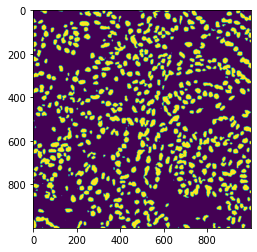

In [11]:
plt.imshow(pred.argmax(dim=0).detach().cpu().numpy())

In [12]:
pred_np = pred.argmax(dim=0).detach().cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


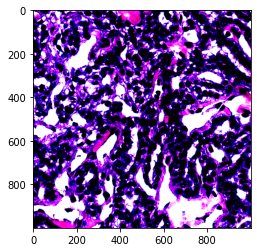

In [13]:
plt.imshow(i.transpose_(0,2).transpose_(0,1))

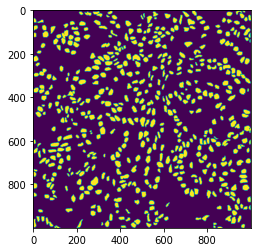

In [14]:
plt.imshow(m)

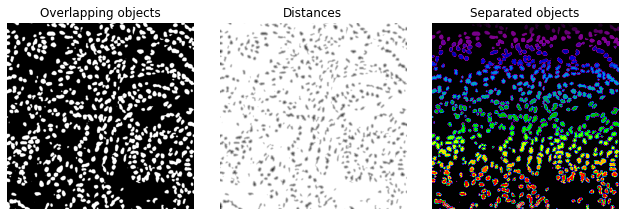

In [16]:
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max


# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(pred_np)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=pred_np)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels_pred = watershed(-distance, markers, mask=pred_np)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(pred_np, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()


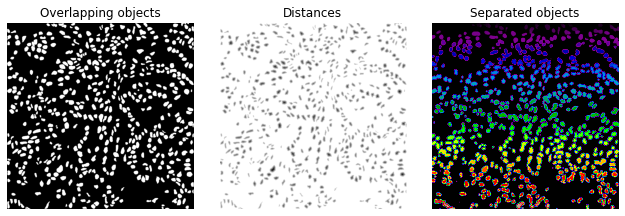

In [18]:
m = np.array(m)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(m)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=m)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
true_labels = watershed(-distance, markers, mask=m)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(m, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

In [19]:
np.unique(labels_pred)

array([   0,    1,    2, ..., 1645, 1646, 1647], dtype=int32)

In [20]:
np.unique(true_labels)

array([   0,    1,    2, ..., 1658, 1659, 1660], dtype=int32)

In [22]:
true_labels

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [23]:
list_gt = np.unique(true_labels)

In [24]:
len(list_gt)

1661

In [27]:
markers_pred = np.zeros(np.shape(np.unique(labels_pred))) 

In [28]:
len(markers_pred)

1648

In [30]:
g = 3 
mask_g = np.where(true_labels!=g,0,true_labels)

In [32]:
np.unique(mask_g)

array([0, 3], dtype=int32)

In [38]:
mask_g

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

(array([0, 3], dtype=int32), array([999980,     20]))

In [39]:
res = np.where(mask_g == g )

In [47]:
res

(array([2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 7, 7, 7]),
 array([946, 947, 946, 947, 948, 949, 946, 947, 948, 949, 946, 947, 948,
        949, 946, 947, 948, 946, 947, 948]))

In [48]:
true_labels[7,948]

3

In [55]:
overlap = []
for i in range(len(res[0])):
    coord = (res[0][i],res[1][i])
    overlap.append(labels_pred[coord])

overlap = np.unique(overlap)
    

In [56]:
overlap

array([5], dtype=int32)

In [53]:
coord

(7, 948)

In [54]:
labels_pred[coord]

5

In [64]:
for s in overlap: 
    mask_s = np.where(labels_pred!=s,0,labels_pred)
    mask_s = np.where(mask_s==s,g,mask_s)

In [65]:
mask_s

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [66]:
np.unique(mask_s)

array([0, 3], dtype=int32)

In [67]:
intersection = np.logical_and(mask_g, mask_s)
union = np.logical_or(mask_g, mask_s)
iou_score = np.sum(intersection) / np.sum(union)

In [68]:
iou_score

0.07326007326007326

In [69]:
intersection

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [70]:
union

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [71]:
np.sum(union)

273

In [72]:
np.sum(intersection)

20

In [75]:
res = np.where(mask_s==g)

In [76]:
res

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 

In [77]:
np.where(labels_pred==s)

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,
         7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,
         8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
         8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
         9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 

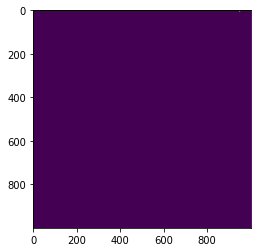

In [79]:
plt.imshow(mask_g)

In [82]:
iou = [0.7,0.5,13]

In [83]:
np.argmax(iou)

2

In [84]:
markers_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [85]:
len(markers_pred)

1648

In [86]:
np.unique(labels_pred)

array([   0,    1,    2, ..., 1645, 1646, 1647], dtype=int32)

In [88]:
markers_pred[1648]

IndexError: index 1648 is out of bounds for axis 0 with size 1648

In [89]:
iou = []

In [90]:
np.argmax(iou)

ValueError: attempt to get argmax of an empty sequence